<center><h2 style='color:red'>HuBMAP | Pytorch | ViT for Segmentation [Train]<hr>By Kassem@elcaiseri</h2></center>

This Code depends on: <br>
- The lossses are from **https://github.com/JunMa11/SegLoss**
- The base codes are from here: **https://www.kaggle.com/vineeth1999/hubmap-pytorch-efficientunet-offline**

**Update:**
- It's the official code. https://github.com/Beckschen/TransUNet


- It's the paper of the TransUnet. https://arxiv.org/pdf/2102.04306v1.pdf (Thanks for @luciusk)


## Introduction <br>
Implementation of **self attention mechanisms** for computer vision in PyTorch with einsum and einops. Focused on **segmentation**  self-attention modules.

### Note: This is a baseline code

**Update**
- This code starts from vision 10
- **V15**: - Use DiceBCELoss - increase ViT blocks - 
- **V16**: - Apply Official code.
          - Add more options for loss function.

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import GroupKFold

import torch
import torchvision
from torch import nn
from torch.optim import Adam
from torchvision import transforms
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts

import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from scipy.ndimage.interpolation import zoom

import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
import sys
import time
import random

## Hyperparameters

In [35]:
class CFG:
    data = 256 #512
    debug=False
    apex=False
    print_freq=100
    num_workers=4
    img_size=256 # appropriate input size for encoder 
    scheduler='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epoch=5 # Change epochs
    criterion= 'Lovasz' #'DiceBCELoss' # ['DiceLoss', 'Hausdorff', 'Lovasz']
    base_model='Unet' # ['Unet']
    encoder = 'vit' # ['attention','efficientnet-b5'] or other encoders from smp
    lr=1e-4
    min_lr=1e-6
    batch_size=4
    weight_decay=1e-6
    gradient_accumulation_steps=1
    seed=2021
    n_fold=5
    trn_fold= 0 #[0, 1, 2, 3, 4]
    train=True
    inference=False
    optimizer = 'Adam'
    T_0=10
    # N=5 
    # M=9
    T_max=10
    #factor=0.2
    #patience=4
    #eps=1e-6
    smoothing=1
    in_channels=3
    vit_blocks=12 #[8, 12]
    vit_linear=1024 #1024
    classes=1
    MODEL_NAME = 'R50-ViT-B_16'


main_dir = 'data'
train_dir = 'data/train-1'
masks_dir = 'data/masks-1'

In [45]:
# from @Iafoss comment
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #the following line gives ~10% speedup
    #but may lead to some stochasticity in the results 
    torch.backends.cudnn.benchmark = True # from @Iafoss comment

seed_torch(seed=CFG.seed)

## Dataset

In [37]:
train_df = pd.read_csv('data/train-1.csv')
train_df.head()

,label_name,bbox_x,bbox_y,bbox_width,bbox_height,id,image_width,image_height
0,shuizhong,11,208,244,31,1-1-1.jpg,256,256
1,shuizhong,1,195,255,34,1-1-2.jpg,256,256
2,shuizhong,0,197,61,25,1-1-3.jpg,256,256
3,shuizhong,38,212,218,21,1-1-8.jpg,256,256
4,shuizhong,1,208,252,30,1-1-9.jpg,256,256


In [38]:
def get_transform(mode='base'):
    if mode == 'base':
        base_transform = A.Compose([
            A.Resize(CFG.img_size, CFG.img_size, p=1.0),
            A.HorizontalFlip(),
            A.VerticalFlip(),
            A.RandomRotate90(),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.4, 
                             border_mode=cv2.BORDER_REFLECT),
            A.OneOf([
                A.OpticalDistortion(p=0.4),
                A.GridDistortion(p=.1),
                A.PiecewiseAffine(p=0.4),
            ], p=0.3),
            A.OneOf([
                A.HueSaturationValue(10,15,10),
                A.CLAHE(clip_limit=3),
                A.RandomBrightnessContrast(),            
            ], p=0.4),
            ToTensorV2()
        ], p=1.0)
        return base_transform
    
    elif mode == 'rand':
        rand_transform = A.Compose([
                RandAugment(CFG.N, CFG.M),
                A.Transpose(p=0.5),
                A.VerticalFlip(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
                A.Resize(CFG.img_size, CFG.img_size, p=1.0),
                A.Normalize(),
                ToTensorV2()
            ])
        return rand_transform
    
    elif mode == 'strong':
        strong_transform = A.Compose([
                A.Transpose(p=0.5),
                A.VerticalFlip(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
                A.OneOf([
                        A.RandomGamma(),
                        A.GaussNoise()           
                    ], p=0.5),
                A.OneOf([
                        A.OpticalDistortion(p=0.4),
                        A.GridDistortion(p=0.2),
                        A.PiecewiseAffine(p=0.4),
                    ], p=0.5),
                A.OneOf([
                        A.HueSaturationValue(10,15,10),
                        A.CLAHE(clip_limit=4),
                        A.RandomBrightnessContrast(),            
                    ], p=0.5),

                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
                A.Resize(CFG.img_size, CFG.img_size, p=1.0),
                ToTensorV2()
            ])
        return strong_transform
    
    elif mode == 'weak':
        weak_transform = A.Compose([
                A.Resize(CFG.img_size, CFG.img_size, p=0.5),
                A.HorizontalFlip(),
                A.VerticalFlip(),
                A.RandomRotate90(),
                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.4, 
                                 border_mode=cv2.BORDER_REFLECT),
                ToTensorV2()
            ], p=1.0)
        return weak_transform
    
    elif mode == 'valid':
        val_transform = A.Compose([
                A.Resize(CFG.img_size, CFG.img_size, p=1.0),
                ToTensorV2()
            ], p=1.0)
        return val_transform
    
    else:
        print('Unknown mode.')
    

mean = np.array([0.65459856,0.48386562,0.69428385])
std = np.array([0.15167958,0.23584107,0.13146145])

In [35]:
# def get_transform(mode='base'):
#     if mode == 'base':
#         base_transform = A.Compose([
#             A.Resize(CFG.img_size[0], CFG.img_size[1], p=1.0),  # 修改这里
#             A.HorizontalFlip(),
#             A.VerticalFlip(),
#             A.RandomRotate90(),
#             A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.4, 
#                                border_mode=cv2.BORDER_REFLECT),
#             A.OneOf([
#                 A.OpticalDistortion(p=0.4),
#                 A.GridDistortion(p=.1),
#                 A.PiecewiseAffine(p=0.4),
#             ], p=0.3),
#             A.OneOf([
#                 A.HueSaturationValue(10,15,10),
#                 A.CLAHE(clip_limit=3),
#                 A.RandomBrightnessContrast(),            
#             ], p=0.4),
#             ToTensorV2()
#         ], p=1.0)
#         return base_transform
    
#     elif mode == 'rand':
#         rand_transform = A.Compose([
#             RandAugment(CFG.N, CFG.M),
#             A.Transpose(p=0.5),
#             A.VerticalFlip(p=0.5),
#             A.HorizontalFlip(p=0.5),
#             A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
#             A.Resize(CFG.img_size[0], CFG.img_size[1], p=1.0),  # 修改这里
#             A.Normalize(),
#             ToTensorV2()
#         ])
#         return rand_transform
    
#     elif mode == 'strong':
#         strong_transform = A.Compose([
#             A.Transpose(p=0.5),
#             A.VerticalFlip(p=0.5),
#             A.HorizontalFlip(p=0.5),
#             A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
#             A.OneOf([
#                     A.RandomGamma(),
#                     A.GaussNoise()           
#                 ], p=0.5),
#             A.OneOf([
#                     A.OpticalDistortion(p=0.4),
#                     A.GridDistortion(p=0.2),
#                     A.PiecewiseAffine(p=0.4),
#                 ], p=0.5),
#             A.OneOf([
#                     A.HueSaturationValue(10,15,10),
#                     A.CLAHE(clip_limit=4),
#                     A.RandomBrightnessContrast(),            
#                 ], p=0.5),
#             A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
#             A.Resize(CFG.img_size[0], CFG.img_size[1], p=1.0),  # 修改这里
#             ToTensorV2()
#         ])
#         return strong_transform
    
#     elif mode == 'weak':
#         weak_transform = A.Compose([
#             A.Resize(CFG.img_size[0], CFG.img_size[1], p=0.5),  # 修改这里
#             A.HorizontalFlip(),
#             A.VerticalFlip(),
#             A.RandomRotate90(),
#             A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.4, 
#                                border_mode=cv2.BORDER_REFLECT),
#             ToTensorV2()
#         ], p=1.0)
#         return weak_transform
    
#     elif mode == 'valid':
#         val_transform = A.Compose([
#             A.Resize(CFG.img_size[0], CFG.img_size[1], p=1.0),  # 修改这里
#             ToTensorV2()
#         ], p=1.0)
#         return val_transform
    
#     else:
#         print('Unknown mode.')


In [7]:
class HuBMAPDataset(Dataset):
    def __init__(self, main_dir, df, train=True, transform=None):
        
        self.ids = df.id.values
        self.fnames = [fname for fname in os.listdir(train_dir) if fname.split('_')[0] in self.ids]

        self.main_dir = main_dir
        self.df = df
        self.train = train
        self.transform = transform
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        
        img = cv2.cvtColor(cv2.imread(os.path.join(main_dir, 'train', fname)), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(main_dir, 'masks', fname),cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)            
            img, mask = aug['image'], aug['mask']
                    
        img = img.type('torch.FloatTensor')
        img = img/255
        mask = mask.type('torch.FloatTensor')

        return img, mask
          

In [42]:
class HuBMAPDataset(Dataset):
    def __init__(self, main_dir, df, train=True, transform=None):
        """
        :param main_dir: 主目录路径，包含图像文件夹和掩码文件夹
        :param df: DataFrame，包含数据集的相关信息（id等）
        :param train: 是否用于训练集
        :param transform: 数据增强的变换
        """
        # 从传入的 DataFrame 获取图像 ID
        self.ids = df['id'].values
        
        # 获取所有图像的文件名，确保图像 ID 对应 CSV 文件中的 id
        # self.fnames = [fname for fname in os.listdir(os.path.join(main_dir, 'train')) if fname.split('_')[0] in self.ids]
        self.fnames = [fname for fname in os.listdir(train_dir) if fname.split('_')[0] in self.ids]
        
        # 图像和标签的主目录
        self.main_dir = main_dir
        self.df = df
        self.train = train
        self.transform = transform

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        # 获取当前文件名
        fname = self.fnames[idx]
        
        # 读取图像
        img = cv2.cvtColor(cv2.imread(os.path.join(self.main_dir, 'train', fname)), cv2.COLOR_BGR2RGB)

        # 获取对应的标签（根据文件名查找DataFrame中匹配的行）
        img_id = fname.split('.png')[0]  # 假设图像文件名没有扩展名，或根据实际情况修改
        img_labels = self.df[self.df['id'] == img_id]
        
        # 创建一个空的掩码图像，和原图像大小相同
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        
        # 遍历每个边界框，绘制掩码
        for _, row in img_labels.iterrows():
            # 获取边界框坐标
            x, y, w, h = row['bbox_x'], row['bbox_y'], row['bbox_width'], row['bbox_height']
            
            # 绘制矩形区域，将区域内的像素值设置为1
            mask[y:y+h, x:x+w] = 1
        
        # 应用数据增强（如果有）
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']
        
        # 转换图像和标签格式
        img = img.astype('float32') / 255  # 归一化到 [0, 1]
        img = torch.tensor(img).permute(2, 0, 1).type(torch.FloatTensor)  # 转换为 (C, H, W) 格式
        
        mask = torch.tensor(mask).type(torch.FloatTensor)  # 保持掩码为 (H, W) 格式

        return img, mask


## Visualize augmented data

In [43]:
def vis_aug_data(dataset, length=10):
    plt.figure(figsize=(15,10))
    N = length // 2
    for i in range(length):
        image, mask = train_dataset[i]
        plt.subplot(3,4,2*i+1)
        plt.imshow(np.transpose((image), (1,2,0)))
        plt.axis('off')
        plt.subplot(3,4,2*i+2)
        plt.imshow(mask)
        plt.axis('off')

In [31]:
def vis_aug_data(dataset, length=10):
    # 确保 length 不超过数据集的长度
    dataset_length = len(dataset)
    length = min(length, dataset_length)  # 使用较小的值
    
    plt.figure(figsize=(15,10))
    N = length // 2
    
    for i in range(length):
        image, mask = dataset[i]  # 修改为传入的 dataset
        plt.subplot(3, 4, 2*i+1)
        plt.imshow(np.transpose(image, (1, 2, 0)))  # 转置到 (H, W, C) 格式
        plt.axis('off')
        
        plt.subplot(3, 4, 2*i+2)
        plt.imshow(mask)
        plt.axis('off')
    
    plt.show()

In [44]:
# base augmentation
train_dataset = HuBMAPDataset(main_dir, train_df, train=True, transform=get_transform('base'))

vis_aug_data(train_dataset, 6)

IndexError: list index out of range

<Figure size 1500x1000 with 0 Axes>

In [45]:
# weak augmentation
train_dataset = HuBMAPDataset(main_dir, train_df, train=True, transform=get_transform('weak'))

vis_aug_data(train_dataset, 6)

<Figure size 1500x1000 with 0 Axes>

In [46]:
# strong augmentation
train_dataset = HuBMAPDataset(main_dir, train_df, train=True, transform=get_transform('strong'))

vis_aug_data(train_dataset, 6)

<Figure size 1500x1000 with 0 Axes>

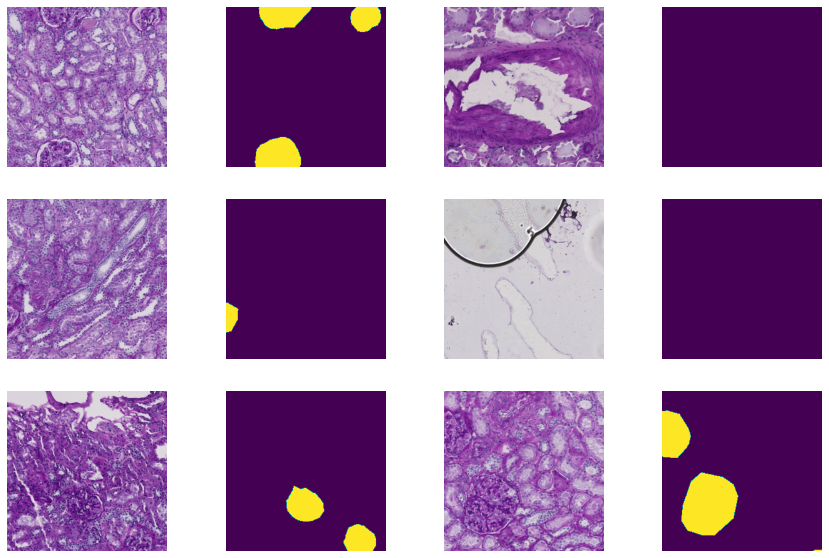

In [12]:
# valid augmentation
train_dataset = HuBMAPDataset(main_dir, train_df, train=True, transform=get_transform('valid'))

vis_aug_data(train_dataset, 6)

## DataLoader

In [13]:
if CFG.data==512:
    directory_list = os.listdir('../input/hubmap-512x512/train')
elif CFG.data==256:
    directory_list = os.listdir('../input/hubmap-256x256/train')
directory_list = [fnames.split('_')[0] for fnames in directory_list]
dir_df = pd.DataFrame(directory_list, columns=['id'])
dir_df

,id
0,8242609fa
1,e79de561c
2,2f6ecfcdf
3,afa5e8098
4,aaa6a05cc
...,...
9575,1e2425f28
9576,26dc41664
9577,26dc41664
9578,e79de561c


## Model

In [ ]:
!wget https://storage.googleapis.com/vit_models/imagenet21k/R50%2BViT-B_16.npz
#! pip install self-attention-cv
!pip install einops
!pip install ml_collections
tu_path = '../input/transunet/TransUNet-main'
sys.path.append(tu_path)

'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [ ]:
from vit_seg_modeling import VisionTransformer as ViT_seg
from vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg

config_vit = CONFIGS_ViT_seg[CFG.MODEL_NAME]
config_vit.n_classes = 1
config_vit.n_skip = 3
config_vit.pretrained_path = './R50+ViT-B_16.npz'
config_vit.transformer.dropout_rate = 0.2
config_vit.transformer.mlp_dim = 3072
config_vit.transformer.num_heads = 4
config_vit.transformer.num_layers = 8

config_vit

ModuleNotFoundError: No module named 'networks.vit_seg_modeling'

In [16]:
class ViTHuBMAP(nn.Module):
    def __init__(self, configs=config_vit):
        super(ViTHuBMAP, self).__init__()
        
        self.model = ViT_seg(configs, img_size=CFG.img_size, num_classes=CFG.classes)
        self.model.load_from(weights=np.load(configs.pretrained_path))

    
    def forward(self, x):
        img_segs = self.model(x)
        
        return img_segs

## Loss Function

In [17]:
sys.path.append('../input/segloss/Segmentationloss/SegLoss-master')
from losses_pytorch.hausdorff import HausdorffDTLoss
from losses_pytorch.lovasz_loss import LovaszSoftmax
from losses_pytorch.focal_loss import FocalLoss

In [49]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=CFG.smoothing):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return dice
    
    
    
class DiceBCELoss(nn.Module):
    # Formula Given above.
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=CFG.smoothing):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).mean()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.mean() + targets.mean() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE.mean()
    
    
class Hausdorff_loss(nn.Module):
    def __init__(self):
        super(Hausdorff_loss, self).__init__()
        
    def forward(self, inputs, targets):
        return HausdorffDTLoss()(inputs, targets)
    
class FocalDLoss(nn.Module):
    def __init__(self):
        super(FocalDLoss, self).__init__()
        
    def forward(self, inputs, targets):
        return FocalLoss()(inputs, targets)
    
    
class Lovasz_loss(nn.Module):
    def __init__(self):
        super(Lovasz_loss, self).__init__()
        
    def forward(self, inputs, targets):
        return LovaszSoftmax()(inputs, targets)

In [19]:
if CFG.criterion == 'DiceBCELoss':
    criterion = DiceBCELoss()
elif CFG.criterion == 'DiceLoss':
    criterion = DiceLoss()
elif CFG.criterion == 'FocalLoss':
    criterion = FocalDLoss()
elif CFG.criterion == 'Hausdorff':
    criterion = Hausdorff_loss()
elif CFG.criterion == 'Lovasz':
    criterion = Lovasz_loss()

## Train Function

In [20]:
def HuBMAPLoss(images, targets, model, device, loss_func=criterion):
    model.to(device)
    images = images.to(device)
    targets = targets.to(device)
    outputs = model(images)
    loss_func = loss_func
    loss = loss_func(outputs, targets)
    return loss, outputs

In [21]:
def train_one_epoch(epoch, model, device, optimizer, scheduler, trainloader):
    model.train()
    t = time.time()
    total_loss = 0
    
    for step, (images, targets) in enumerate(trainloader):
        loss, outputs = HuBMAPLoss(images, targets, model, device)
        loss.backward()
        if ((step+1)%4==0 or (step+1)==len(trainloader)):
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        loss = loss.detach().item()
        total_loss += loss
        
        if ((step+1)%10==0 or (step+1)==len(trainloader)):
            print(
                    f'epoch {epoch} train step {step+1}/{len(trainloader)}, ' + \
                    f'loss: {total_loss/len(trainloader):.4f}, ' + \
                    f'time: {(time.time() - t):.4f}', end= '\r' if (step + 1) != len(trainloader) else '\n'
                )

            
        
def valid_one_epoch(epoch, model, device, optimizer, scheduler, validloader):
    model.eval()
    t = time.time()
    total_loss = 0
    
    for step, (images, targets) in enumerate(validloader):
        loss, outputs = HuBMAPLoss(images, targets, model, device)
        loss = loss.detach().item()
        total_loss += loss
        
        if ((step+1)%4==0 or (step+1)==len(validloader)):
            scheduler.step(total_loss/len(validloader))
        
        if ((step+1)%10==0 or (step+1)==len(validloader)):
            print(
                    f'**epoch {epoch} trainz step {step+1}/{len(validloader)}, ' + \
                    f'loss: {total_loss/len(validloader):.4f}, ' + \
                    f'time: {(time.time() - t):.4f}', end= '\r' if (step + 1) != len(validloader) else '\n'
                )

        

## Creating Folds Column

In [22]:
FOLDS = CFG.n_fold
gkf = GroupKFold(FOLDS)
dir_df['Folds'] = 0
for fold, (tr_idx, val_idx) in enumerate(gkf.split(dir_df, groups=dir_df[dir_df.columns[0]].values)):
    dir_df.loc[val_idx, 'Folds'] = fold
    
dir_df

,id,Folds
0,8242609fa,3
1,e79de561c,0
2,2f6ecfcdf,4
3,afa5e8098,2
4,aaa6a05cc,2
...,...,...
9575,1e2425f28,1
9576,26dc41664,4
9577,26dc41664,4
9578,e79de561c,0


## The Real Training

In [23]:
def prepare_train_valid_dataloader(df, fold):
    train_ids = df[~df.Folds.isin(fold)]
    val_ids = df[df.Folds.isin(fold)]
    
    train_ds = HuBMAPDataset(main_dir, train_ids, train=True, transform=get_transform('base'))
    val_ds = HuBMAPDataset(main_dir, val_ids, train=True, transform=get_transform('valid'))
    
    train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, pin_memory=True, shuffle=True, num_workers=CFG.num_workers)
    val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, pin_memory=True, shuffle=False, num_workers=CFG.num_workers)
    
    return train_loader, val_loader

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViTHuBMAP().to(device)
optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)

# scheduler setting
if CFG.scheduler == 'CosineAnnealingWarmRestarts':
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
elif CFG.scheduler == 'ReduceLROnPlateau':
    scheduler = ReduceLROnPlateauReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
elif CFG.scheduler == 'CosineAnnealingLR':
    scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)

load_pretrained: grid-size from 14 to 16


In [25]:
print(f'Training Loop [{CFG.trn_fold}]...')
for fold, (tr_idx, val_idx) in enumerate(gkf.split(dir_df, groups=dir_df[dir_df.columns[0]].values)):
    if fold != CFG.trn_fold: # Train only one fold
        continue 

    trainloader, validloader = prepare_train_valid_dataloader(dir_df, [fold])

    for epoch in range(CFG.epoch):
        train_one_epoch(epoch, model, device, optimizer, scheduler, trainloader)
        with torch.no_grad():
            valid_one_epoch(epoch, model, device, optimizer, scheduler, validloader)
        
        #torch.save(model.state_dict(),f'FOLD-{fold}-EPOCH-{epoch}-model.pth')
        
    torch.save(model.state_dict(),f'FOLD-{fold}-model.pth')
    
    #del model, optimizer, scheduler, trainloader, validloader

Training Loop [0]...
epoch 0 train step 1925/1925, loss: 0.1029, time: 452.8129
**epoch 0 trainz step 471/471, loss: 0.0223, time: 32.5438
epoch 1 train step 1925/1925, loss: 0.0226, time: 451.6797
**epoch 1 trainz step 471/471, loss: 0.0351, time: 30.9149
epoch 2 train step 1925/1925, loss: 0.0175, time: 448.5032
**epoch 2 trainz step 471/471, loss: 0.0200, time: 30.5493
epoch 3 train step 1925/1925, loss: 0.0178, time: 449.4928
**epoch 3 trainz step 471/471, loss: 0.0209, time: 30.6923
epoch 4 train step 1925/1925, loss: 0.0160, time: 450.9324
**epoch 4 trainz step 471/471, loss: 0.0224, time: 30.9721


## Plot the results 

In [26]:
trainloader, validloader = prepare_train_valid_dataloader(dir_df, [4])

In [27]:
def plot_result(validloader, n_sample=4):
    img, mask = next(iter(validloader))
    model.load_state_dict(torch.load(f'./FOLD-{CFG.trn_fold}-model.pth'))
    pred_mask = model(img.to(device)).squeeze(1).cpu().detach()
    
    N = n_sample // 2
    assert (N < CFG.batch_size)
    plt.figure(figsize=(15, 20))
    for i in range(n_sample):
        plt.subplot(N, 4, 2*i+1)
        plt.imshow(np.transpose(img[i], (1,2,0)))
        plt.axis('off')
        
        plt.subplot(N, 4, 2*i+2)
        plt.imshow(pred_mask[i])
        plt.axis('off')

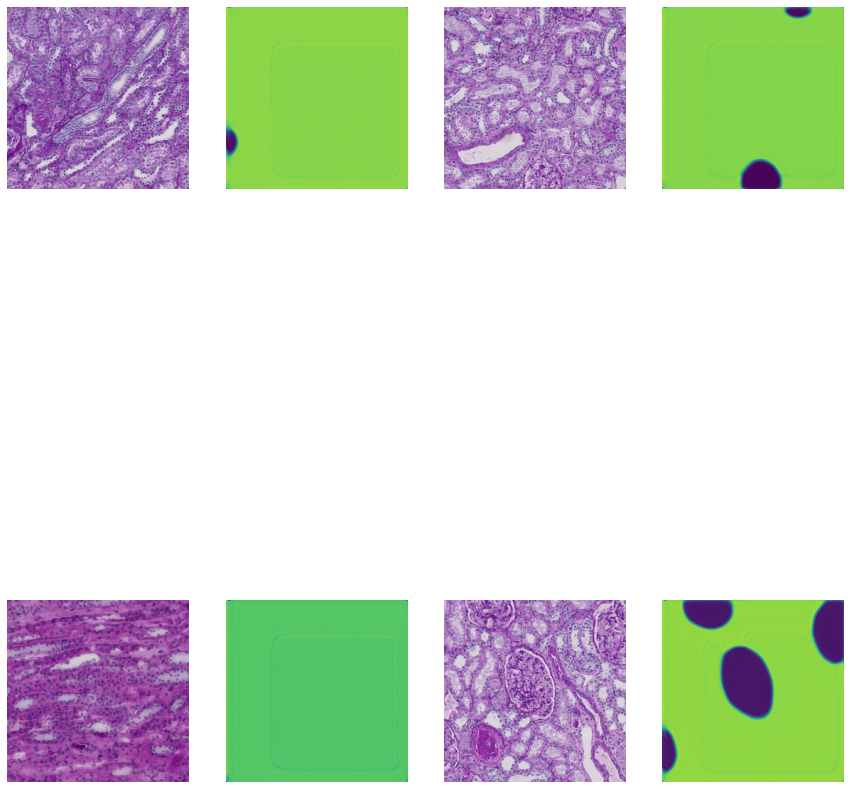

In [28]:
with torch.no_grad():
    plot_result(validloader)

## What you should do to improve the results:
- Use data normalization
- Use anthor implementation for TransUnet (Applied in V16)
- Reduce the probability of the augmentations
- Play with visionTrans hyperparameters

<CENTER><h3><span style='color:red'> UPVOTE </span> If you liked</h3>
<h4>Code still under modifications, Stay tuned</h4></CENTER>